In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
import eli5
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
from tqdm import tqdm

Using TensorFlow backend.


In [ ]:
df = data_tracks.get_data()
n = df.shape[0]

In [ ]:
# preprocess
# predict using the trace
X_mat = data_tracks.extract_X_mat(df)
X_mat -= np.mean(X_mat)
X_mat /= np.std(X_mat)
y = df['y_thresh'].values.astype(np.int64)


# train / test split
cell_nums_train = [1, 2, 3, 4]
idxs = df.cell_num.isin(cell_nums_train)
idxs_test = df.cell_num.isin([5])
X_train, Y_train = X_mat[idxs], y[idxs]
X_test, Y_test = X_mat[idxs_test], y[idxs_test]

conv_size = 30
num_channels = 3
out_dir = 'results/maxconv'
os.makedirs(out_dir, exist_ok=True)
dirname = oj(out_dir, f'conv_size={conv_size}_num_conv={num_channels}')

net = NeuralNetClassifier(
    nn.Sequential(models.MaxConv(kernel_size=conv_size, num_units=num_channels), 
                  nn.Linear(1, 2), nn.Softmax()),
    max_epochs=1000,
    lr=1e-3,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cpu'
)

net.fit(X_train, Y_train)

Re-initializing optimizer.


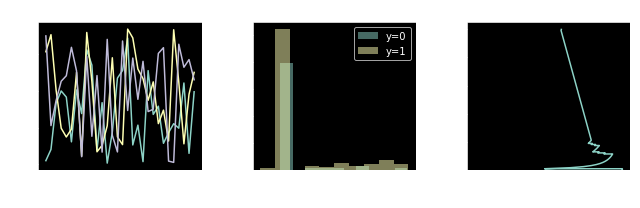

class imbalance 0.61
acc 0.61
roc_auc 0.50
balanced acc: 0.50


In [14]:
# visualize model

# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)

R, C = 1, 3
plt.figure(figsize=(3 * C, 3 * R))
ws = net.module_.state_dict()['0.conv1.weight'].cpu().numpy().squeeze()
# print(ws.shape)

plt.subplot(R, C, 1)
plt.title(f'filters (offset ={net.module_.state_dict()["0.offset"].cpu().numpy().squeeze():0.3f})')
plt.plot(ws.T)
plt.xlabel('t')

plt.subplot(R, C, 2)
preds = net.predict_proba(X_test)
preds_labels = net.predict(X_test)
# plt.plot(Y_train, preds[:, 1], 'o', alpha=0.01)
plt.hist(preds[:, 1][Y_test == 0], label='y=0', alpha=0.5)
plt.hist(preds[:, 1][Y_test == 1], label='y=1', alpha=0.5)
plt.title(f'acc {np.mean(Y_test == preds_labels):0.2f} balanced: {metrics.balanced_accuracy_score(Y_test, preds_labels):0.2f}' ) #' r2 {metrics.r2_score(Y_train, preds):0.2f}')
# plt.xlabel('Y')
plt.legend()
plt.xlabel('pred')

plt.subplot(R, C, 3)
precision, recall, thresholds = metrics.precision_recall_curve(Y_test, preds[:, 1])
plt.plot(precision, recall)
plt.xlim((0, 1.05))
plt.ylim((0, 1.05))
plt.xlabel('precision')
plt.ylabel('recall')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()

print(f'class imbalance {np.mean(Y_test):0.2f}')
print(f'acc {np.mean(Y_test == preds_labels):0.2f}')
print(f'roc_auc {metrics.roc_auc_score(Y_test, preds_labels):0.2f}')
print(f'balanced acc: {metrics.balanced_accuracy_score(Y_test, preds_labels):0.2f}') #' r2 {metrics.r2_score(Y_train, preds):0.2f}')